# NEURAL NETWORK OBJECT RECOGNITION

## PROJECT

UoEO Machine Learning

Assignment Due Date: 20 January, 2025

## AUTHOR

Maria Ingold

## PROJECT DESCRIPTION

Your ML model should address following points:
1. Introduction: Introduce CIFAR-10 and perform basic Exploratory Data Analysis (EDA)
2. Partition and Validation: Method to partition the validation set from the training data, insights into metadata, importance of separate validation.
3. Artificial Neural Network Architecture: Elaborate.
4. Activation Function: What and why selected.
5. Loss Function: Describe what and why implemented.
6. Epochs, Batch Size, Learning Rate: Number and why.
7. Evalution: Insights on Neural Network design elements strategy.
8. Conclusion: Reflections on learnings acquired.


## IMPORT LIBRARIES

In [1]:
import numpy as np                                   # numerical computation
import matplotlib.pyplot as plt                      # plots
import tensorflow as tf                              # machine learning
from tensorflow.keras.datasets import cifar10        # CIFAR-10 dataset
from sklearn.model_selection import train_test_split # train test split
from tensorflow.keras.utils import to_categorical    # one-hot encoding

## LOAD DATASET

CIFAR-10 (Krizhevsky, 2009)
- 60,000 32x32 colour images
- 10 classes, 6000 images per class
- 50,000 training
- 10,000 testing



In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## EXPLORATORY DATA ANALYSIS (EDA)

### Shape

- Training data shape: 50,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Training labels: 50,000 labels of just one name
- Training data shape: 10,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Testing lables shape: 10,000 labels of just one name

In [3]:
# Inspect the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


### Constant
- class names as mapped by CIFAR-10
- 10 classes map to the following:
- 0 = airplane
- 1 = automobile
- 2 = bird
- 3 = cat
- 4 = deer
- 5 = dog
- 6 = frog
- 7 = horse
- 8 = ship
- 9 = truck


In [4]:
LABEL_NAMES = ['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualise

- Ten random images per label name

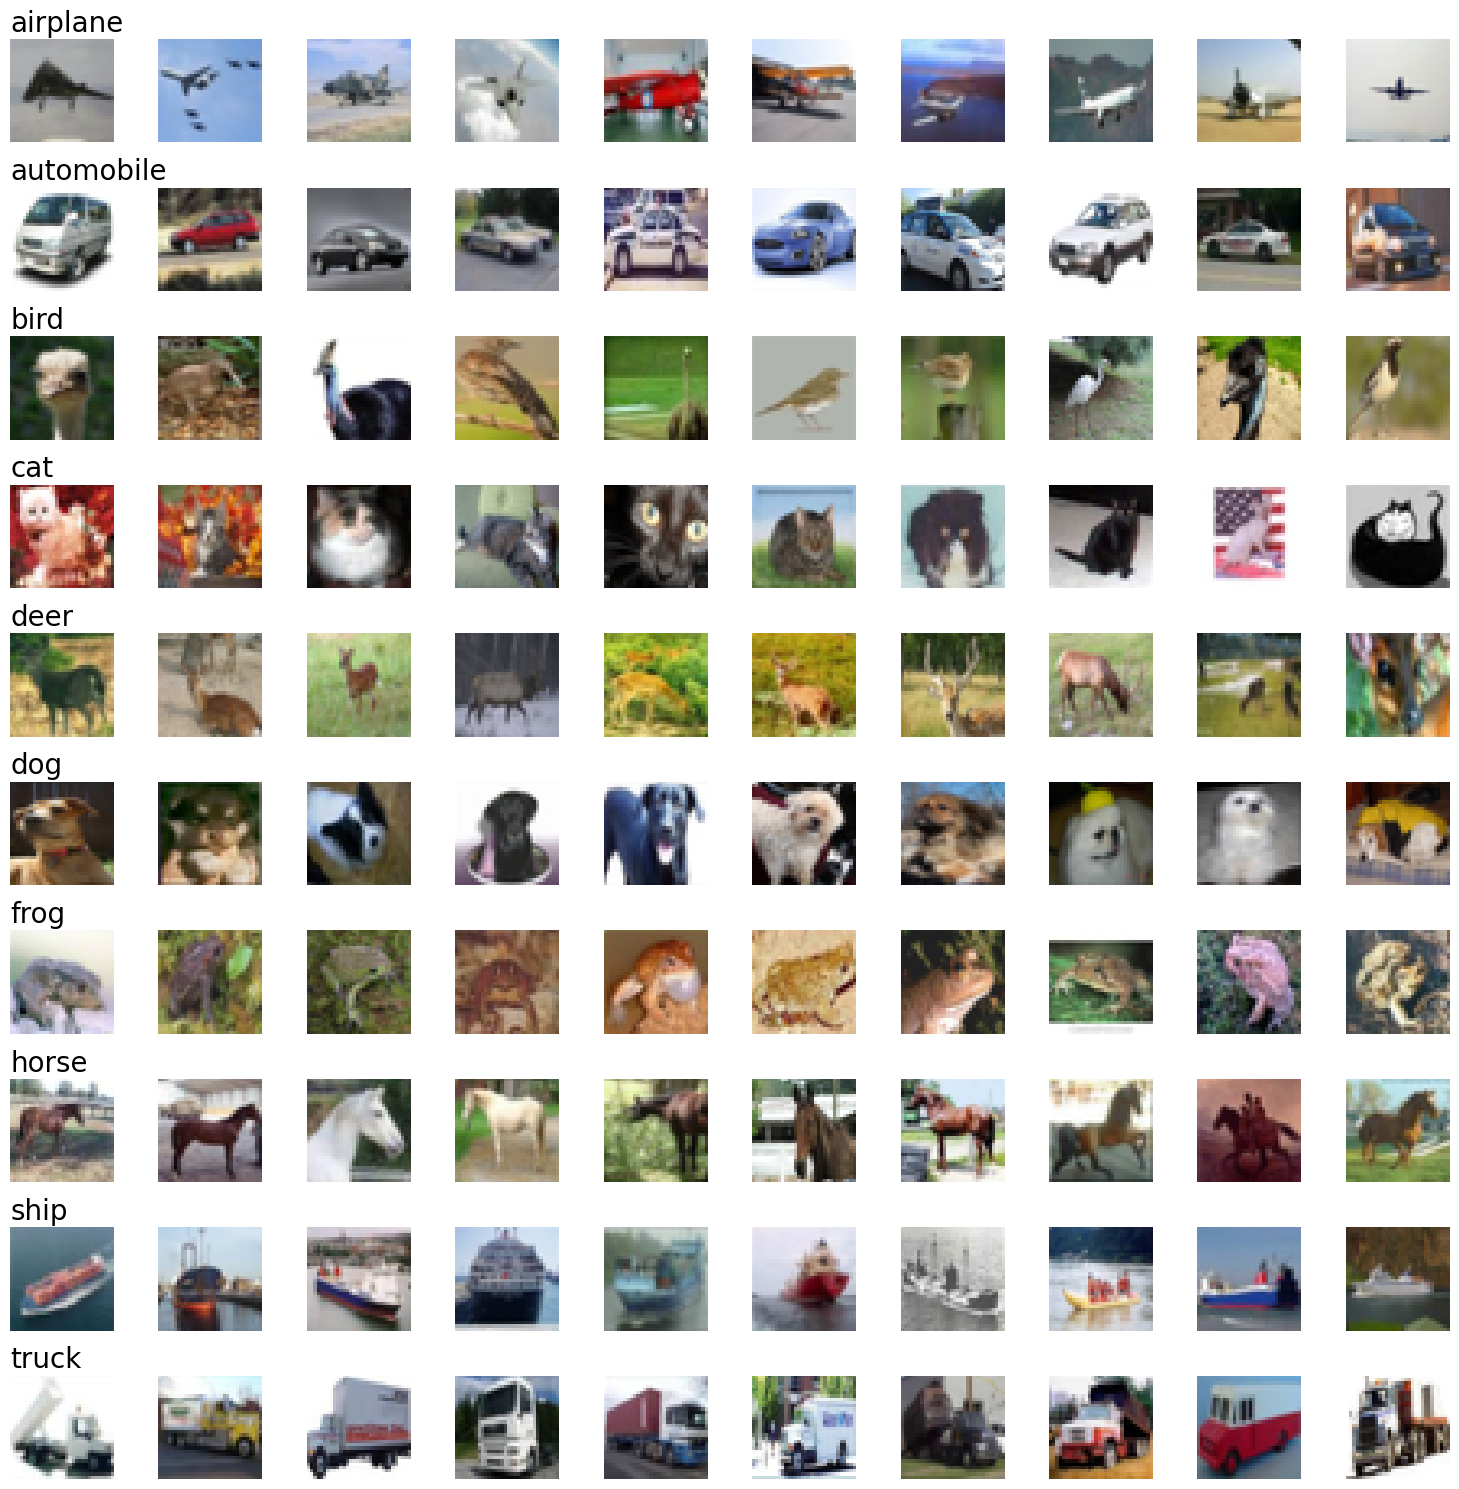

In [5]:
# Number of samples to display per class
num_samples = 10

# Create a figure
fig, axes = plt.subplots(len(LABEL_NAMES), num_samples, figsize=(15, 15))

# Iterate over each class
for class_idx, class_name in enumerate(LABEL_NAMES):
    # Find the indices of images belonging to the current class
    class_indices = np.where(y_train.flatten() == class_idx)[0]

    # Randomly select `num_samples` images from the class
    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Plot the images
    for i, img_idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(x_train[img_idx])
        ax.axis("off")
        if i == 0:  # Add class name only on the first image
            ax.set_title(class_name, fontsize=20, loc="left")

# Adjust layout and display
plt.tight_layout()
plt.show()

## PARTITION TRAINING INTO VALIDATION
Dataset comes with
- training set (50,000)
- test set (10,000)

Now split training set into:
- training set
- validation set

Rationale:
- *** Research here as to correct size.
- 10%, 20%?????

Result:
- training set (40,000)
- validation set (10,000)
- test set (10,000)

In [6]:
# Split the training data into training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0)

# Check the new shapes
print(f"New training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"New training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")

New training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
New training labels shape: (40000, 1)
Validation labels shape: (10000, 1)


## PRE-PROCESSING

- Preprocess after partitioning to not influence the test set.
- Normalise
- One-hot encode class labels

### Normalise

- RGB channel pixel value intensities range from 0 to 255
- 0 = black
- 255 (original) or 1 (normalised) = full intensity
- Red (R) channel = 0
- Green (G) channel = 1
- Blue (B) channel = 2
- Normalising helps Neural Network

#### Understand the data

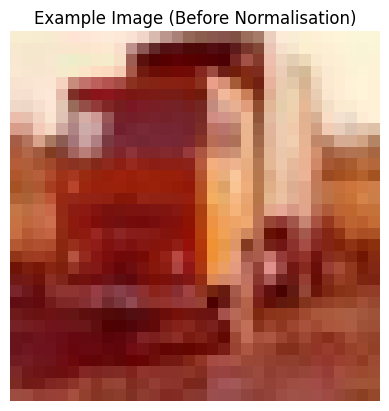

Pixel values (partial):
[[248 248 247 246 252]
 [247 245 245 246 248]
 [248 245 246 248 241]
 [250 248 247 248 246]
 [248 248 251 251 245]]


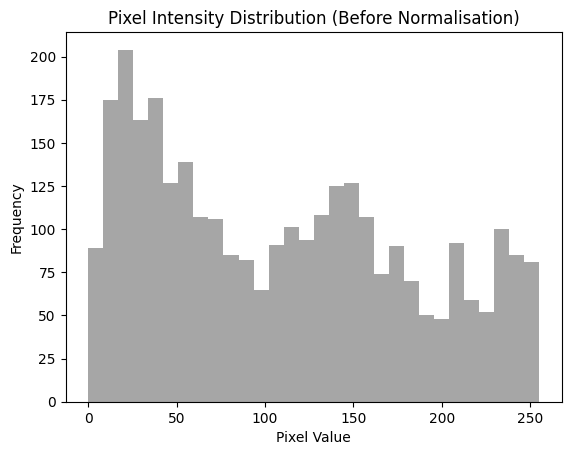

In [7]:
# Choose an example image from the training set
example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (Before Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for first five rows and columns of image
print("Pixel values (partial):")
print(example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (Before Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Display the original range of pixel values
print("Original pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Original pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Original pixel range (test):", np.min(x_test), "to", np.max(x_test))

Original pixel range (train): 0 to 255
Original pixel range (validate): 0 to 255
Original pixel range (test): 0 to 255


#### Normalise RGB from [0, 255] to [0, 1]

In [9]:
# Normalize the image data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_validate = x_validate.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Display the new range of pixel values
print("Normalized pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Normalized pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Normalized pixel range (test):", np.min(x_test), "to", np.max(x_test))

Normalized pixel range (train): 0.0 to 1.0
Normalized pixel range (validate): 0.0 to 1.0
Normalized pixel range (test): 0.0 to 1.0


#### Understand the normalisation change

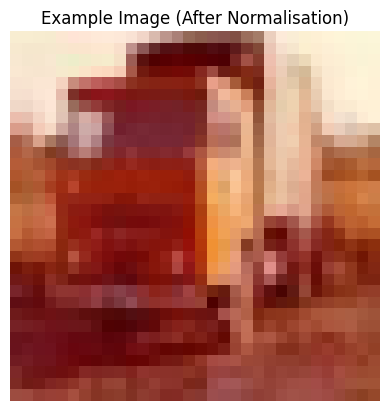

Pixel values (partial):
[[0.972549   0.972549   0.96862745 0.9647059  0.9882353 ]
 [0.96862745 0.9607843  0.9607843  0.9647059  0.972549  ]
 [0.972549   0.9607843  0.9647059  0.972549   0.94509804]
 [0.98039216 0.972549   0.96862745 0.972549   0.9647059 ]
 [0.972549   0.972549   0.9843137  0.9843137  0.9607843 ]]


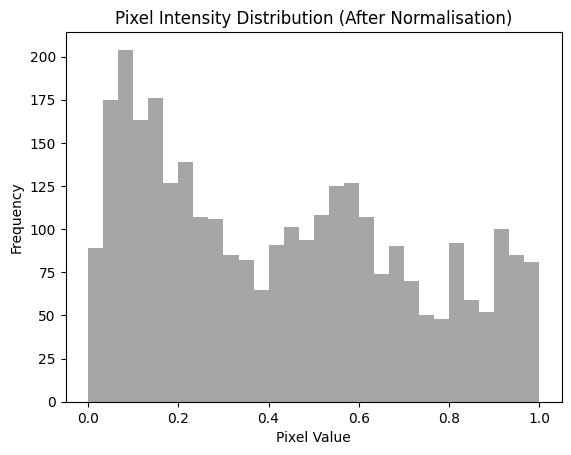

In [10]:
# Choose an example image from the training set
normalised_example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (After Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for the first few rows of the image
print("Pixel values (partial):")
print(normalised_example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(normalised_example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (After Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

### One-hot encode
- [9] is truck
- [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] is one-hot encoding of [9] and still means truck

In [11]:
# Show an example label before one-hot encoding
print("Label before one-hot encoding:", y_train[100])

# Convert class labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)
y_validate = to_categorical(y_validate, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Label after one-hot encoding:", y_train[100])

Label before one-hot encoding: [9]
Label after one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### Shape

- Data is still the same shape
- Labels are now 10, not 1

In [12]:
# Check the shapes of the preprocessed data
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Training labels shape: (40000, 10)
Validation labels shape: (10000, 10)
Testing labels shape: (10000, 10)


## NEURAL NETWORK ARCHITECTURE

- Activation function

- model = Sequential()
- model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
- model.add(MaxPooling2D((2, 2)))
- model.add(Conv2D(64, (3, 3), activation='relu'))
- model.add(MaxPooling2D((2, 2)))
- model.add(Flatten())
- model.add(Dense(64, activation='relu'))
- model.add(Dense(10, activation='softmax'))

## COMPILE THE MODEL

- Setting up the optimizer, loss function, and metrics.
- model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## INTIALISE PARAMETERS

- Set weights and biases

## CHOOSE LOSS FUNCTION AND OPTIMISER

## TRAIN THE MODEL
- history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


## VALIDATION

## TESTING

## EVALUATE THE MODEL
- test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
- 313/313 - 3s - loss: 0.9097 - accuracy: 0.7019 - 3s/epoch - 10ms/step

## TUNE THE MODEL

## DEPLOY THE MODEL

## CONCLUSION
- Here we can summarize the results and discuss potential next steps or improvements.
- plt.plot(history.history['accuracy'], label='accuracy')
- plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
- plt.xlabel('Epoch')
- plt.ylabel('Accuracy')
- plt.ylim([0, 1])
- plt.legend(loc='lower right')
- plt.show()